# 4IM01 - Skin Lesions - Giordmaina - Bonninière

In [1]:
from display_image import viewimage, viewimgs, view3imgs
import cv2

## Objectif 
Le projet s'intéresse à l'analyse d'images dermatologiques de lésion cutanées. Le but est de créer un pipeline prenant en entrée une image dermatologique présentant une lésion et d'obtenir le masque binaire de cette lésion pour permettre l'analyse par des médecins. Les images que nous analysons sont toutes du même types. La liaison est toujours située au centre de l'image. On cherche donc à utiliser une méthode de segmentation pour obtenir le masque biniare de chaque lésion. 

### Position du problème de la segmentation

L'un des enjeux de l'analyse de ce type d'image dermatologique est que l'acquisition n'est jamais identique et que notre pipeline doit s'adpater à tous les différents types de peaux et de lésions. En effet, les images sont diverses, et présentent des contrastes variés. Ainsi, on peut retrouver des zones sombres qui compliquent l'application de la segmentation. Les lésions peuvent être aussi plus ou moins marquées et contrastées ce qui peut empêcher une segmentation facile. La présence de poils est aussi un des enjeux de la segmentation puisqu'ils gênent l'identification de la lésion en elle-même. 

Les images ci-dessous montrent cette pluralité au sein des images dermatologiques que l'on considére : 
 

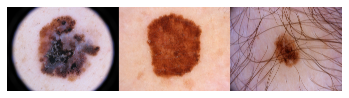

In [3]:
img4, img7, img19 = cv2.imread('images_test/img4.jpg'), cv2.imread('images_test/img7.jpg'), cv2.imread('images_test/img19.jpg')
view3imgs(img4, img7, img19)

### Organisation du pipeline

Le pipeline mis en oeuvre pour obtenir les masques binaires de segmentation des lésions cutanées se divisent en trois partie
Le pipeline mis en oeuvre pour obtenir les masques binaires de segmentation des lésions cutanées se divisent en trois parties distinctes : le pre-processing, la segmentation et le post-processing.

#### Pre-processing : 

Les étapes de pre-processing ont pour objectif de "nettoyer" l'image originale pour améliorer la qualité de l'output de l'algortihme de segmentation qui sera ensuite appliqué à l'image dermatologique. On distingue deux sous-étapes dans ce pré-traitement de l'image : le black frame removal et le hair removal. 

En effet, certaines images présentent des zones sombres ou noires dans les coins qui interférent avec les algorithme de hair removal et de segmentation. Le premier défi est donc de venir sélectionner ces zones noires, les blacks frames, pour ne pas les prendre en compte dans la suite du traitement au sein du pipeline. 

Ensuite, on cherche à retirer les potentiels poils présents sur les images car ceux-ci sont sombres et interfèrent fortement avec les lésions qui sont, elles aussi, sombre. 


#### Méthode de segmentation d'Otsu :

Pour mieux comprendre pourquoi le pre-processing est primordial, il est d'abord nécessaire de s'attarder sur la méthode de segmentation que nous avons utilisée. Il s'agit de la méthode de segmentation d'Otsu qui permet une segmentation binaire entre 2 classes (parties distinctes de l'image) et qui repose sur la maximisation de la variance inter-classe. On fixe un certain seuil de niveau de gris puis, en définissant la variance de chaque classe puis inter-classe, on cherche le seuil qui va maximiser cette variance interclasse. On peut alors appliquer un seuillage binaire à l'image pour obtenir un masque binaire. Du fait de cette binarisation par recherche d'un seuil permettant de séparer l'image en deux parties, on remarque que l'impact des poils et des black frames est très important puiqu'ils interfèrent lors de la définition des deux classes qui initialement doivent être la peau (classe C0) et la lésion (classe C1). 


#### Post-processing : 

Cette dernière partie du pipeline permet de lisser et de nettoyer le masque binaire obtenu après les deux premières étapes. De fait, après la segmentation le masque n'est pas lisse et on va chercher à obtenir une unique composante connexe au centre de l'image correspondant au masque de la lésion. 

#### Contrôle de qualité du masque et score Dice :

A la sortie du pipeline on obtient un masque binaire de notre lésion cutanée. Pour pouvoir s'asurer que le masque et la segmentation sont de bonnes qualité, on vient les comparer à des masques de référence réalisés par des médecins. Pour mesurer la ressemblance ou la "distance" entre deux masques, on utilise le Dice qui est un score qui calcule la proximité entre deux images binaires. Le Dice est un score entre 0 et 1. Plus le score est proche de 1, plus les deux masques sont proches, plus le masque obtenu par le pipeline est de qualité. 

#### Organisation du code : 

Chaque module effectue une tâche précise au sein du pipeline : 

- pre-processing : `blk_removal.py`, `___DUlL_RAZOR.py`
- segmentation : `otsu_seg.py`
- post-processing : `post_processing.py`
- affichage : `display_image`
- fichiers de tests : `main_test.py`(fichier principale), `test_otsu_full.py`, `test_otsu_postpro1.py`, `test_otsu_prepro1.py`, et `test_otsu_simple.py`


## Segmentation par Otsu : 

Pour se rendre compte de l'interêt de l'intégralité du pipeline, on s'intéresse en premier lieu à notre méthode de segmentation seule, Otsu. COmme déja mentionné précédemment, elle repose sur la définition de deux classes à l'aide d'un seuil de niveau de gris permettant de maximiser la variance inter-classe. La segmentation par Otsu est développée dans le module `otsu_seg.py`. Pour la méthode d'Otsu, on passe l'image de départ en niveaux de gris avec la fonction `cvtColor` et son attribut `cv2.COLOR_BGR2GRAY` du module `cv2`.

Dans un premier temps, on calcule l'histogramme de l'image avec `calcHist` de `cv2`. Puis on normalise l'histogramme pour avoir la probabilité d'apparition de chaque niveau de gris, avec la fonction `prob_gray_lvl`. On est alors en mesure de calculer la probabilité de chaque classeet sa moyenne en fonction du seuil t, et finalement la variance inter-classe toujours en fonction de t à l'aide de la fonction `var_between_class`. C'est cette variance qu'on maximiser dans la fonction `otsu`qui fournit le seuil correspondant. C'est avec cette valeur de seuil qu'on applique le seuillage binaire ensuite. 

## Pre-processing : 

### Black frames removal : 

Dans cette partie du pre-processing, on s'intéresse aux images qui présentent des bords noirs ou des zones sombres qui doivent être "enlèvés" ou du moins identifiés pour ne pas être pris en compte dans la suite du pipeline. Pour venir sélectionner ces zones indésirables de l'image, on travaille par _region growing_. 

Dans les quatres coins de l'image on vérifie sur quatres sets de pixels carrés (dont la taille et la position sont des paramètres) qu'il y a des zones noires. Pour vérifier que ces sets de pixels sont noirs, on calcule leur moyenne et on compare cette valeur à un certain _tau_ (seuil qui est aussi un paramètre du pipeline). Si l'image n'a pas de zones noires alors cette étape n'est pas nécessaire et on retourne donc l'image originale pour continuer le pipeline. En revanche, si on trouve des sets noires dans les coins de l'image, on démarre le processus de _region growing_. A partir de chaque set de pixels, on initialise une liste d'attente des pixels noirs à visiter et une liste rassemblant toutes les coordonnées des pixels noirs qui ont déja été visités. En parcourant chaque voisin de chaque pixel noir identifié, toujours définis comme étant les pixels inférieurs à un certain seuil _tau_, on peut alors rassembler de proche en proche tous les pixels noirs indésirables situés sur les bords de notre image. 


Une fois que tous les pixels noirs des bords de notre image ont été visités, leurs coordonées sont retournées sous forme d'un masque qui va permettre de ne pas les prendre en compte dans les autres étapes du pipeline. Ce masque est renvoyé par la fonction `mask_remove` du module `blk_removal.py`. Les pixels à ne pas prendre en compte sont marqués comme **False** et les pixels à prendre en compte (qui constituent la partie de l'image à étudier) sont marqués comme **True**. 


### Dull razor : 



In [3]:
from main_test import table_score, D

table_score(D)

| Image | Otsu | Otsu + Pre-processing 1 | Otsu + Post-processing 1 | Otsu + Pre-processing 1 + Post-processing 1 
| --- | --- | --- | --- | --- 
| Image 1 | 0.5134209823144532 | 0.6320512425307814 | 0.41320006330810705 | 0.5166862191172112 |
| Image 2 | 0.8436236464093941 | 0.8917028910478629 | 0.7318447239936899 | 0.7711007645945575 |
| Image 3 | 0.5942052940741882 | 0.5942052940741882 | 0.43210989833811475 | 0.43210989833811475 |
| Image 4 | 0.5744715554050264 | 0.8605290977280661 | 0.5130723679921277 | 0.794508094873971 |
| Image 5 | 0.8779847726195018 | 0.8779847726195018 | 0.8004015831440482 | 0.8004015831440482 |
| Image 6 | 0.7009878098677075 | 0.7009878098677075 | 0.6168739975330731 | 0.6168739975330731 |
| Image 7 | 0.9866045254550194 | 0.9866045254550194 | 0.9282809907307551 | 0.9282809907307551 |
| Image 8 | 0.8752530381450363 | 0.9109996676556317 | 0.8101284635462627 | 0.8369433056694331 |
| Image 9 | 0.7971805809321781 | 0.7971805809321781 | 0.6861635745021127 | 0.6861635745021127 |
| Image 10 | 0.8083436896545131 | 0.8083436896545131 | 0.6671730474207745 | 0.6671730474207745 |
| Image 11 | 0.9267625639057613 | 0.9267625639057613 | 0.8224452855027152 | 0.8224452855027152 |
| Image 12 | 0.9796347984625072 | 0.9796347984625072 | 0.7407616892911011 | 0.7407616892911011 |
| Image 13 | 0.9309017778858711 | 0.9309017778858711 | 0.799868760382155 | 0.799868760382155 |
| Image 14 | 0.8590606920837974 | 0.8590606920837974 | 0.7658476001396085 | 0.7658476001396085 |
| Image 15 | 0.0 | 0.0 | 0.0 | 0.0 |
| Image 16 | 0.7545538243487034 | 0.7545538243487034 | 0.6805793587760732 | 0.6805793587760732 |
| Image 17 | 0.5156797709360423 | 0.8609673681975024 | 0.4668190960348013 | 0.7684920126064458 |
| Image 18 | 0.9402448642977528 | 0.9402448642977528 | 0.8777130276738652 | 0.8777130276738652 |
| Image 19 | 0.41579751544542615 | 0.009231687340531128 | 0.7197054046107648 | 0.00988695562399727 |
| Image 20 | 0.6714143625820211 | 0.7305599584735316 | 0.6035746014734352 | 0.6566008223425908 |
